
### Dataset Information

In my analysis the following dataset is used
* **COVID-19 RADIOGRAPHY DATABASE** 
<br> A team of researchers from Qatar University, Doha, Qatar, and the University of Dhaka, Bangladesh along with their collaborators from Pakistan and Malaysia in collaboration with medical doctors have created a database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images. The database consists of 3616 COVID-19 positive cases along with 10,192 Normal, 6012 Lung Opacity (Non-COVID lung infection), and 1345 Viral Pneumonia images.<br>
[Link to the dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) 

**If you like my work please upvote**

# **1.Importing Libraries**

In [1]:
import os 
import pandas as pd
import glob
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
import cv2
from sklearn.metrics import multilabel_confusion_matrix
import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# **2. Creating datasets**

In [2]:
def generate_dataset_from_directory(folder_path, size = 224,batch_size = 32): 

    '''fetch all out test data from directory
    folder path is a list of n directories for n class classification '''

    image_generator = ImageDataGenerator(
        samplewise_center=True, #Set each sample mean to 0.
        samplewise_std_normalization= True, # Divide each input by its standard deviation]
        #rescale=1./255,
        validation_split = 0.2
    )

    #create training and testing datasets
    train_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="grayscale",
        target_size = (size, size),
        batch_size  = batch_size,
                                                     
        shuffle=True,
        seed=123,
        subset="training"
    )

    #create training and testing datasets
    val_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="grayscale",
        target_size = (size, size),
        batch_size  = batch_size,
        shuffle=True,
        seed=123,
        subset="validation"
    )

#     total_images = train_data.n  
#     steps = total_images//batch_size 
#     xtrain , ytrain = [] , []
#     for i in range(steps):
#         a , b = train_data.next()
#         xtrain.extend(a) 
#         ytrain.extend(b)

#     total_images = val_data.n  
#     steps = total_images//batch_size 
#     xval , yval = [] , []
#     for i in range(steps):
#         a , b = val_data.next()
#         xval.extend(a) 
#         yval.extend(b)

    return train_data, val_data

def get_filepath_from_generator(gen):
    if gen.batch_index <=0:
        raise ValueError('Use iterator to move to batch_index > 0')
    idx_l = (gen.batch_index - 1) * gen.batch_size
    idx_r = idx_l + gen.batch_size if idx_l >= 0 else None
    indices = gen.index_array[idx_l:idx_r]
    filenames = [gen.filenames[i] for i in indices]
    return indices, filenames
    



In [3]:

folder_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/'
train_data, val_data = generate_dataset_from_directory(
    folder_path, size = 128,batch_size = 32)


Found 29632 images belonging to 4 classes.
Found 12698 images belonging to 4 classes.


# **3.Exploratory Data Analysis**

In [4]:
class_names = train_data.class_indices
print(class_names)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [5]:
classes = list(class_names.keys())
print(classes)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [6]:
images,labels = next(train_data)
indices,image_path = get_filepath_from_generator(train_data)
labels = np.argmax(labels, axis=1)
class_dict = train_data.class_indices
class_dict_inv = dict((v, k) for k, v in class_dict.items())
y_names = [class_dict_inv[key] for key in labels]

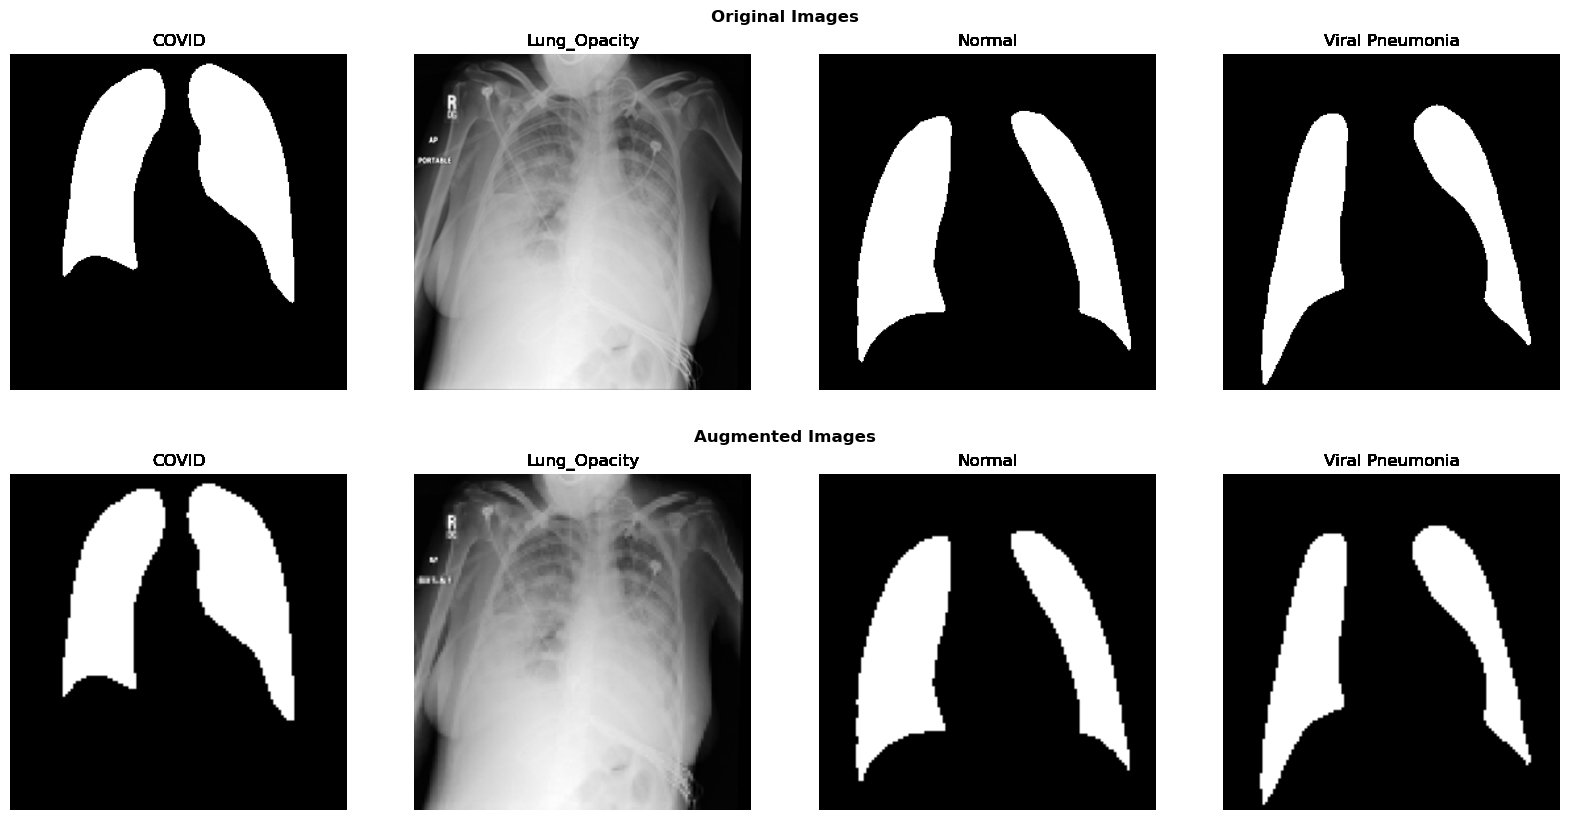

In [7]:
#Preprocessing the images
fig, big_axes = plt.subplots( figsize=(20, 10) , nrows=2, ncols=1, sharey=True) 
titles = ['Original Images','Augmented Images']
for title, big_ax in zip(titles, big_axes):
    big_ax.set_title(f'{title}\n', fontweight='semibold')
    big_ax.set_frame_on = False
    big_ax.axis('off')
for image in images:
    j  = 0
    for i in range(4):
        ax = fig.add_subplot(2, 4, i+1)
        ax1 = fig.add_subplot(2,4,i+1+4)
        for k in range(len(labels)):
            if labels[k] == j:
                og = cv2.imread(folder_path+image_path[k],0)
                ax.imshow(og,cmap = 'gray')
                ax.set_title(classes[i])
                ax.axis("off")
                ax1.imshow(images[k],cmap = 'gray')
                ax1.set_title(classes[i])
                ax1.axis("off")
                break
        j = j+1
plt.show()

In [8]:
# Investigating single original image
def plot_single_image(raw_image,title):
    plt.imshow(raw_image, cmap='gray')
    plt.colorbar()
    plt.title(title)
    print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
    print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
    print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")
    plt.show()

The dimensions of the image are 256 pixels width and 256 pixels height, one single color channel
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 48.5051 and the standard deviation is 100.0802


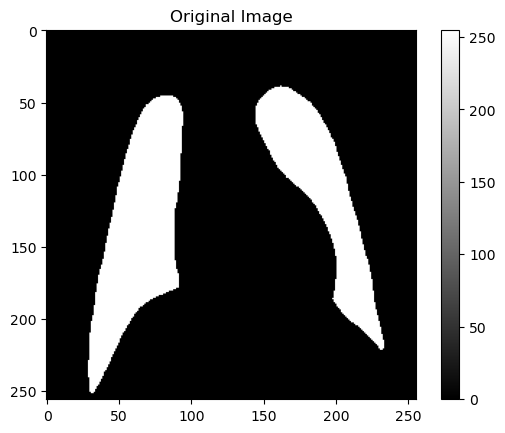

The dimensions of the image are 128 pixels width and 128 pixels height, one single color channel
The maximum pixel value is 2.0651 and the minimum is -0.4842
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


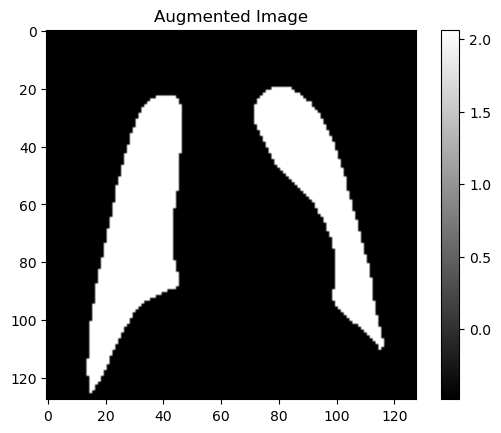

In [9]:
plt.figure(1)
image = cv2.imread(folder_path+image_path[k],0)
plot_single_image(image,'Original Image')
plt.figure(2)
plot_single_image(images[k],'Augmented Image')

/tmp/ipykernel_28/3632709899.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(image.ravel(),
/tmp/ipykernel_28/3632709899.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(images[k].ravel(),


<Figure size 640x480 with 0 Axes>

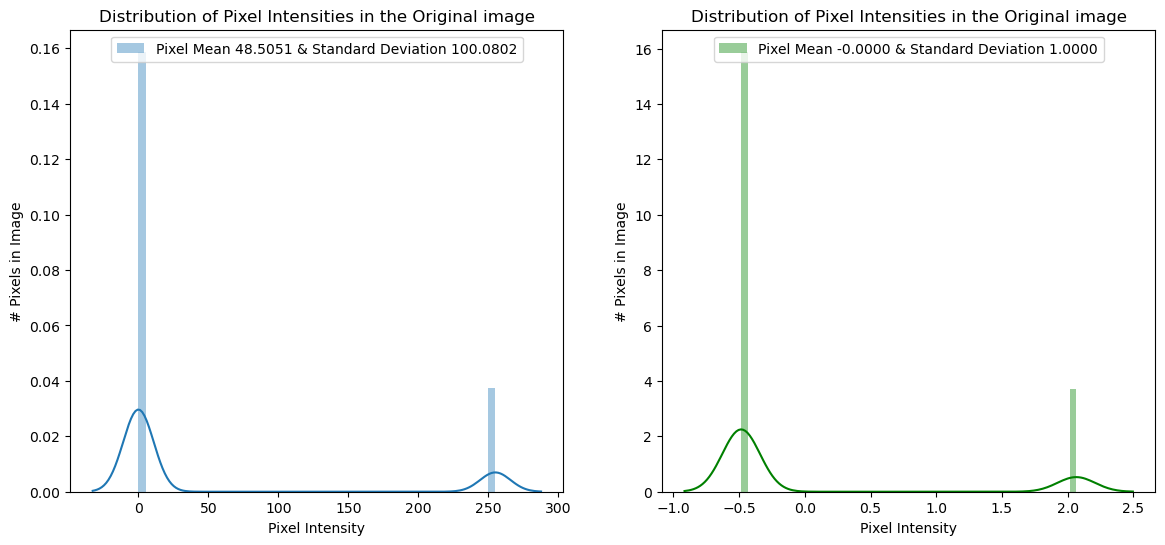

In [10]:
# Plot a histogram of the distribution of the pixels
sns.despine(left=True)
fig,(ax1,ax2) = plt.subplots(1,2,figsize =(14,6))
sns.distplot(image.ravel(), 
             label=f'Pixel Mean {np.mean(image):.4f} & Standard Deviation {np.std(image):.4f}', kde=True, ax = ax1)
ax1.legend(loc='upper center')
ax1.set_title('Distribution of Pixel Intensities in the Original image')
ax1.set_xlabel('Pixel Intensity')
ax1.set_ylabel('# Pixels in Image')

sns.distplot(images[k].ravel(), 
             label=f'Pixel Mean {np.mean(images[k]):.4f} & Standard Deviation {np.std(images[k]):.4f}', kde=True,color = 'green',ax = ax2)
ax2.legend(loc='upper center')
ax2.set_title('Distribution of Pixel Intensities in the Original image')
ax2.set_xlabel('Pixel Intensity')
ax2.set_ylabel('# Pixels in Image')

plt.show()

In [11]:
all_items,dirs,files = next(os.walk(folder_path))

In [12]:
image_in_classes = []
for i in range(len(dirs)):
    no_of_images =len(os.listdir(os.path.join(folder_path,dirs[i])))
    image_in_classes.append(no_of_images)
df_data = {'class': dirs,'counts': image_in_classes}
classes_df = pd.DataFrame(df_data)    
    

In [13]:
n_classes = len(dirs)

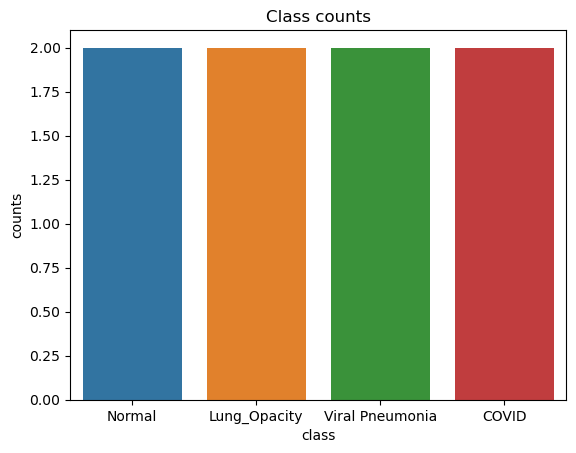

In [14]:
sns.barplot(x = 'class', y = 'counts',data = classes_df)
plt.title('Class counts')
plt.show()

Comment: As you can see the data is highly imbalanced. We have very less cases of viral pneumonia compared to other classes.

# **4. Predictive Modeling**

In [15]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig, ax = plt.subplots(1,2,figsize=(20,10))
  ax[0].plot(epochRange,history.history['accuracy'],'b',label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],'r',label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize = 20)
  ax[0].set_ylabel('Accuracy', fontsize = 20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')
  ax[1].plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize = 20)
  ax[1].set_ylabel('Loss', fontsize = 20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
  plt.show()
    
    
    

### Using VGG

In [16]:
def vgg_model(train_data, test_data, epochs, size):
    print("----Building the model----")

    base_model = VGG19(input_shape=(size, size, 1), weights=None, include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(4, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=out)
    # model.summary()

    print("----Training the network----")
    model.compile(optimizer=Adam(0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience=5,
                               restore_best_weights=True)
    # model_checkpoint
    mc = ModelCheckpoint('vgg_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model.fit(train_data,
                  validation_data=test_data,
                  epochs=epochs,
                  verbose=1,
                  batch_size=32,
                  callbacks=[early_stop, mc])
    print("Train score:", model.evaluate(train_data))
    print("Test score:", model.evaluate(test_data))
    n_epochs = len(r.history['loss'])

    return r, model, n_epochs


In [17]:
epochs = 50
r,model,n_epochs = vgg_model(train_data, val_data,epochs,128)

----Building the model----
----Training the network----
Epoch 1/20
926/926 [==============================] - ETA: 0s - loss: 1.0127 - accuracy: 0.5576
Epoch 1: val_loss improved from inf to 0.76368, saving model to vgg_model.h5
926/926 [==============================] - 360s 373ms/step - loss: 1.0127 - accuracy: 0.5576 - val_loss: 0.7637 - val_accuracy: 0.6887
Epoch 2/20
926/926 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.6988
Epoch 2: val_loss improved from 0.76368 to 0.62189, saving model to vgg_model.h5
926/926 [==============================] - 114s 123ms/step - loss: 0.7405 - accuracy: 0.6988 - val_loss: 0.6219 - val_accuracy: 0.7488
Epoch 3/20
926/926 [==============================] - ETA: 0s - loss: 0.6631 - accuracy: 0.7372
Epoch 3: val_loss improved from 0.62189 to 0.54223, saving model to vgg_model.h5
926/926 [==============================] - 119s 128ms/step - loss: 0.6631 - accuracy: 0.7372 - val_loss: 0.5422 - val_accuracy: 0.7813
Epoch 4/20
9

In [18]:
#from tensorflow.keras.models import load_model
# Load the model
#model = load_model('/kaggle/input/vgg-x-ray-covid19-classification-94-acc/vgg_model.h5')

In [19]:
def extract_from_generator(data):
    data.reset()
    X, y = next(data)
    for i in tqdm.tqdm(range(int(data.n/data.batch_size)-1)): 
        img, label = next(data)
        X = np.append(X, img, axis=0 )
        y = np.append(y, label, axis=0)
    return X,y


In [20]:
#X_train,y_train = extract_from_generator(train_data)
#print('X_train:',X_train.shape,'y_train:',y_train.shape)

In [21]:
X_test,y_test = extract_from_generator(val_data)
print('X_test:',X_test.shape,'y_test:',y_test.shape)

100%|██████████| 395/395 [01:30<00:00,  4.38it/s]

X_test: (12672, 128, 128, 1) y_test: (12672, 4)


In [22]:
y_pred  = np.round(model.predict(X_test))

396/396 [==============================] - 8s 21ms/step


In [23]:
y_test_c = np.argmax(y_test,axis = 1) 
y_pred_c = np.argmax(y_pred,axis = 1)

In [24]:
print(classification_report(y_test,y_pred, target_names=classes_df['class']))

                 precision    recall  f1-score   support

         Normal       0.90      0.79      0.84      2166
   Lung_Opacity       0.89      0.81      0.85      3600
Viral Pneumonia       0.88      0.96      0.91      6099
          COVID       0.97      0.80      0.88       807

      micro avg       0.89      0.88      0.88     12672
      macro avg       0.91      0.84      0.87     12672
   weighted avg       0.89      0.88      0.88     12672
    samples avg       0.88      0.88      0.88     12672



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


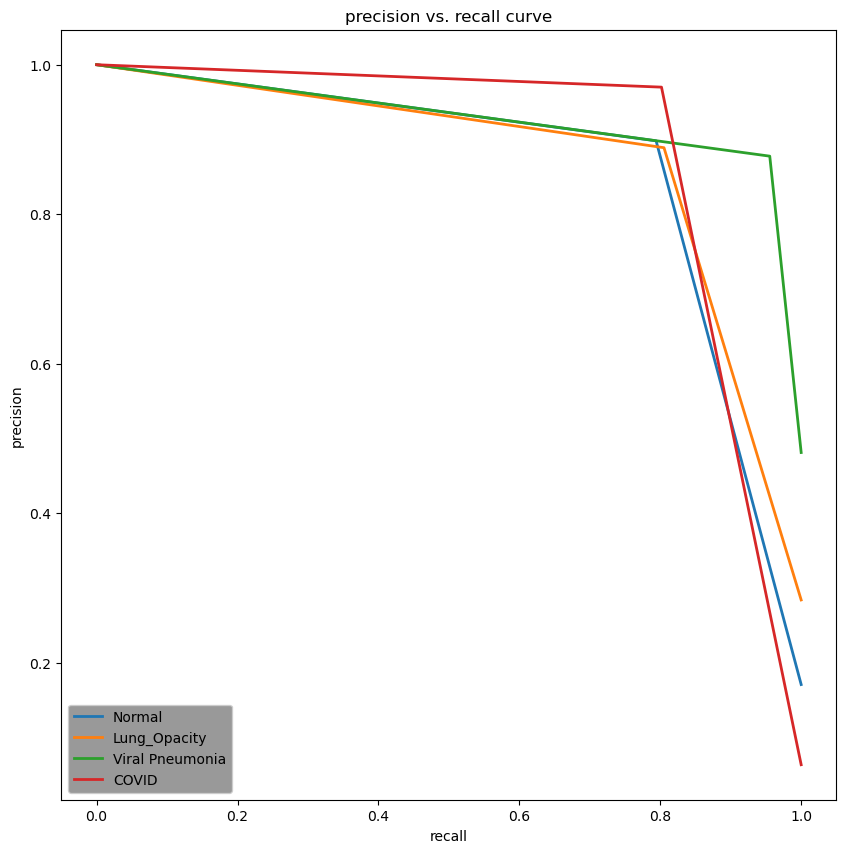

In [25]:
plt.rcParams['axes.facecolor'] = (0.5, 0.5, 0.5, 0.0)


plt.figure(figsize = (10,10))
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=classes_df['class'][i])
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

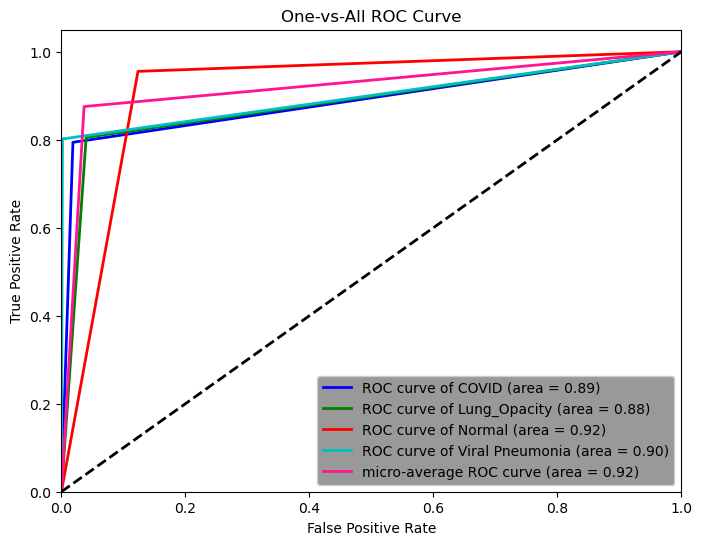

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical


# Determine the number of classes
n_classes = val_data.num_classes

# Initialize variables to store the false positive rate, true positive rate, and ROC AUC score for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.rcParams['axes.facecolor'] = (0.5, 0.5, 0.5, 0.0)

# Compute the false positive rate, true positive rate, and ROC AUC score for each class
for class_name, class_id in val_data.class_indices.items():
    fpr[class_name], tpr[class_name], _ = roc_curve(y_test_c == class_id, y_pred[:, class_id])
    roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])

# Compute the micro-average ROC curve and ROC AUC score
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(y_test_c).ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class and micro-average ROC curve
plt.figure(figsize=(8,6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'][:n_classes]
for i, color in zip(val_data.class_indices.keys(), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {} (area = {:.2f})'.format(i, roc_auc[i]))
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2,
         label='micro-average ROC curve (area = {:.2f})'.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-All ROC Curve')
plt.legend(loc="lower right")
plt.show()


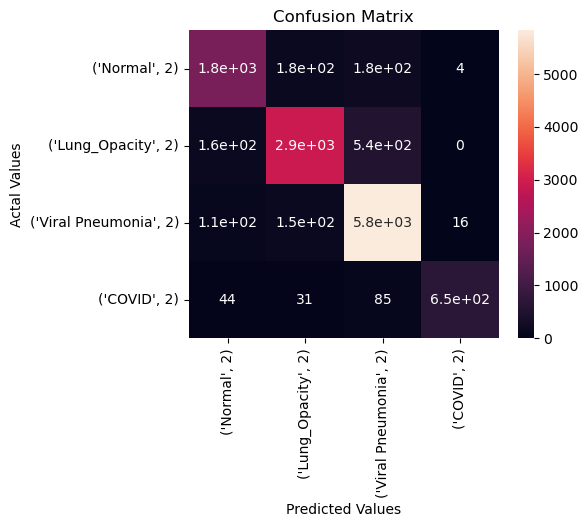

In [27]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cm = confusion_matrix(y_test_c, y_pred_c)

cm_df = pd.DataFrame(cm,
                     index = classes_df, 
                     columns = classes_df)

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()